### 파일 압축 풀기

In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = "/content/drive/My Drive/data_validmask.zip"

extract_to = "/content/unzipped"
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

### 필요 라이브러리 설치

In [ ]:
!pip install torch torchvision

In [ ]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import UperNetForSemanticSegmentation, AutoImageProcessor
from PIL import Image, ImageDraw
import json
import matplotlib.pyplot as plt
from transformers import SegformerImageProcessor
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cv2
from pycocotools.coco import COCO
import albumentations as A
import time

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### 데이터 불러오기

In [ ]:
image_processor = AutoImageProcessor.from_pretrained('openmmlab/upernet-swin-tiny')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

In [ ]:
class CarDamageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_processor):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_processor = image_processor
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

        if not self.image_files:
            raise ValueError("이미지 파일이 없습니다. 올바른 데이터 경로를 확인하세요.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        mask_name = img_name.replace('.jpg', '_mask.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"마스크 파일을 찾을 수 없습니다: {mask_path}")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        inputs = self.image_processor(
            images=image,
            segmentation_maps=mask,
            return_tensors="pt"
        )

        pixel_values = inputs['pixel_values'].squeeze(0)
        labels = inputs['labels'].squeeze(0)

        return {'pixel_values': pixel_values, 'labels': labels}

In [ ]:
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    return {'pixel_values': pixel_values, 'labels': labels}

In [ ]:
train_image_dir = "/content/unzipped/content/car_damage_data_v/train/image"
train_mask_dir = "/content/unzipped/content/car_damage_data_v/masks/train"
valid_image_dir = "/content/unzipped/content/car_damage_data_v/valid/image"
valid_mask_dir = "/content/unzipped/content/car_damage_data_v/masks/valid"

In [ ]:
batch_size = 4

train_dataset = CarDamageDataset(
    image_dir=train_image_dir,
    mask_dir=train_mask_dir,
    image_processor=image_processor
)

valid_dataset = CarDamageDataset(
    image_dir=valid_image_dir,
    mask_dir=valid_mask_dir,
    image_processor=image_processor
)

In [ ]:
print(len(train_dataset))
print(len(valid_dataset))

7062
1513


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
print('Train 배치 개수:', len(train_dataloader))
print('Val 배치 개수:', len(valid_dataloader))

Train 배치 개수: 1766
Val 배치 개수: 379


### 모델 훈련 과정

In [ ]:
model = UperNetForSemanticSegmentation.from_pretrained(
    'openmmlab/upernet-swin-tiny',
    num_labels=2,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/8.98k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/240M [00:00<?, ?B/s]

Some weights of UperNetForSemanticSegmentation were not initialized from the model checkpoint at openmmlab/upernet-swin-tiny and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 512, 1, 1]) in the checkpoint and torch.Size([2, 512, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- auxiliary_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- auxiliary_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 59,827,902
Trainable parameters: 59,827,902


In [ ]:
def calculate_iou(preds, labels, num_classes):
    iou_list = []
    preds = preds.argmax(dim=1)  # Get the class with the highest score
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        label_mask = (labels == cls)
        intersection = (pred_mask & label_mask).sum().item()
        union = (pred_mask | label_mask).sum().item()
        if union > 0:
            iou = intersection / union
            iou_list.append(iou)
    return sum(iou_list) / len(iou_list) if iou_list else 0

In [ ]:
def train_one_epoch(model, dataloader, optimizer, device, num_classes):
    model.train()
    total_loss = 0
    total_iou = 0

    for batch in dataloader:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iou += calculate_iou(outputs.logits, labels, num_classes)

    avg_loss = total_loss / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    return avg_loss, avg_iou

In [ ]:
def validate_one_epoch(model, dataloader, device, num_classes):
    model.eval()
    total_loss = 0
    total_iou = 0

    with torch.no_grad():
        for batch in dataloader:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()
            total_iou += calculate_iou(outputs.logits, labels, num_classes)

    avg_loss = total_loss / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    return avg_loss, avg_iou

In [ ]:
num_classes = 2
num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_mious = []
val_mious = []

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_miou = train_one_epoch(model, train_dataloader, optimizer, device, num_classes)
    val_loss, val_miou = validate_one_epoch(model, valid_dataloader, device, num_classes)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.6f} | Training mIoU: {train_miou:.4f}")
    print(f"Validation Loss: {val_loss:.6f} | Validation mIoU: {val_miou:.4f}")
    print(f"Epoch Duration: {epoch_duration:.2f} seconds\n")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.\n")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_mious.append(train_miou)
    val_mious.append(val_miou)

model.safetensors:   0%|          | 0.00/240M [00:00<?, ?B/s]

Epoch 1/3
Training Loss: 0.282775 | Training mIoU: 0.6107
Validation Loss: 0.234870 | Validation mIoU: 0.6052
Epoch Duration: 629.99 seconds

Best model saved.

Epoch 2/3
Training Loss: 0.226408 | Training mIoU: 0.6567
Validation Loss: 0.220254 | Validation mIoU: 0.6547
Epoch Duration: 625.57 seconds

Best model saved.

Epoch 3/3
Training Loss: 0.203840 | Training mIoU: 0.6851
Validation Loss: 0.215186 | Validation mIoU: 0.6495
Epoch Duration: 626.48 seconds

Best model saved.



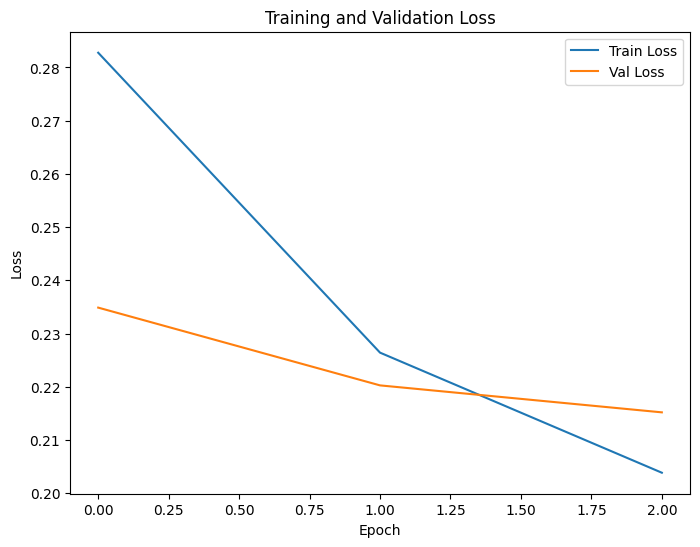

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 모델 저장

In [ ]:
save_path = '/content/drive/My Drive/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

checkpoint_path = os.path.join(save_path, 'SwinTiny_3.pth')
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)

### 모델 테스트

In [ ]:
test_image_dir = "/content/unzipped/content/car_damage_data_v/test/image"
test_mask_dir = "/content/unzipped/content/car_damage_data_v/masks/test"

In [ ]:
test_dataset = CarDamageDataset(
    image_dir=test_image_dir,
    mask_dir=test_mask_dir,
    image_processor=image_processor
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

In [ ]:
import torchvision.transforms.functional as F

CLASS_COLORS = [
    (0, 0, 0),
    (255, 0, 0)
]

In [ ]:
def visualize_segmentation_map(image_tensor, pred_mask, target_size=(512, 512)):
    """
    image_tensor: 원본 이미지 (C, H, W)
    pred_mask: 예측된 마스크 (H, W)
    """
    resized_image = F.resize(F.to_pil_image(image_tensor), target_size)

    pred_mask_color = Image.fromarray(pred_mask.astype('uint8'), mode='P')
    palette = [value for color in CLASS_COLORS for value in color]
    pred_mask_color.putpalette(palette)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(resized_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(pred_mask_color)
    ax[1].set_title("Segmentation Map")
    ax[1].axis("off")

    plt.show()

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))

<ipython-input-27-4e55fec23aa2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

UperNetForSemanticSegmentation(
  (backbone): SwinBackbone(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSel

Testing:   0%|          | 0/379 [00:00<?, ?it/s]

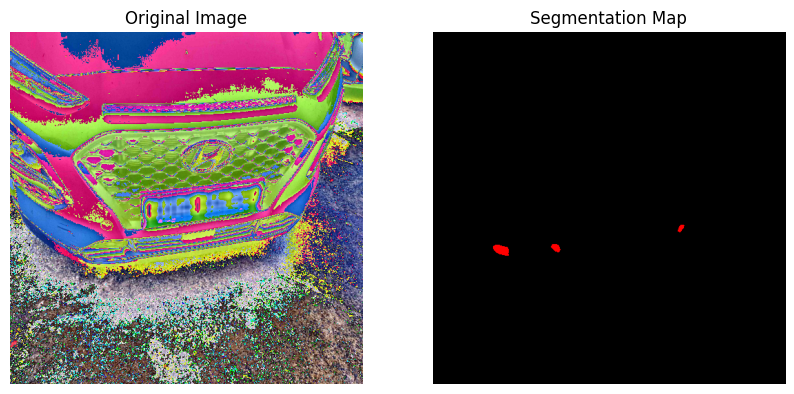

Testing: 100%|██████████| 379/379 [03:41<00:00,  1.71it/s]


In [ ]:
model.eval()
visualized = False

total_accuracy = 0
num_samples = 0
confusion = np.zeros((model.config.num_labels, model.config.num_labels), dtype=np.int64)  # 클래스별 confusion matrix

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        upsampled_logits = torch.nn.functional.interpolate(
            logits,
            size=labels.shape[-2:],
            mode='bilinear',
            align_corners=False
        )

        preds = upsampled_logits.argmax(dim=1)

        batch_preds_flat = preds.cpu().numpy().flatten()
        batch_labels_flat = labels.cpu().numpy().flatten()
        batch_accuracy = accuracy_score(batch_labels_flat, batch_preds_flat)

        total_accuracy += batch_accuracy * len(batch_labels_flat)
        num_samples += len(batch_labels_flat)

        confusion += confusion_matrix(
            batch_labels_flat, batch_preds_flat, labels=list(range(model.config.num_labels))
        )

        if not visualized:
            image_tensor = pixel_values[0].cpu()
            pred_mask = preds[0].cpu().numpy()
            visualize_segmentation_map(image_tensor, pred_mask)
            visualized = True

In [ ]:
overall_accuracy = total_accuracy / num_samples
print(f"Test Accuracy: {overall_accuracy:.4f}")

In [ ]:
def compute_iou(confusion, num_classes):
    ious = []
    for cls in range(num_classes):
        true_positive = confusion[cls, cls]
        false_positive = confusion[:, cls].sum() - true_positive
        false_negative = confusion[cls, :].sum() - true_positive
        union = true_positive + false_positive + false_negative
        if union == 0:
            iou = float('nan')
        else:
            iou = true_positive / union
        ious.append(iou)
    return ious

In [ ]:
num_classes = model.config.num_labels
ious = compute_iou(confusion, num_classes)
mean_iou = np.nanmean(ious)

for idx, iou in enumerate(ious):
    print(f"Class {idx} IoU: {iou:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")

Class 0 IoU: 0.9386
Class 1 IoU: 0.3637
Mean IoU: 0.6511
Class 0 IoU: 0.9386
Class 1 IoU: 0.3637
Mean IoU: 0.6511
